In [1]:
## Import library yang dibutuhkan
import pandas as pd
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from joblib import dump
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

warnings.filterwarnings("ignore")

print("="*60)
print("🚀 MEMULAI PROSES ANALISIS SENTIMEN DENGAN STACKING ENSEMBLE")
print("="*60)

🚀 MEMULAI PROSES ANALISIS SENTIMEN DENGAN STACKING ENSEMBLE


In [2]:
# LOAD DATASET
print("\n📂 STEP 1: LOADING DATASET")
print("-" * 60)
data = pd.read_csv("dc_tweets_mbg_fix.csv")
print(f"✅ Dataset berhasil dimuat!")
print(f"📊 Jumlah baris: {len(data)}")
print(f"📊 Jumlah kolom: {len(data.columns)}")
print(f"📋 Nama kolom: {list(data.columns)}")
print("\n📌 Preview 5 data pertama:")
print(data.head())
print("\n📌 Info dataset:")
print(data.info())


📂 STEP 1: LOADING DATASET
------------------------------------------------------------
✅ Dataset berhasil dimuat!
📊 Jumlah baris: 4899
📊 Jumlah kolom: 2
📋 Nama kolom: ['Sentimen_Title', 'text']

📌 Preview 5 data pertama:
  Sentimen_Title                                               text
0        negatif    program makan gizi gratis kacau distribusi bagi
1         netral  kepala badan gizi nasional program makan gizi ...
2         netral  program makan gizi gratis selaras isu sehat ek...
3         netral            program makan gizi gratis terap sekolah
4         netral  satu layan penuh gizi distribusi makan pusat g...

📌 Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899 entries, 0 to 4898
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sentimen_Title  4899 non-null   object
 1   text            4885 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB
None


In [3]:
# DATA CLEANING
print("\n\n🧹 STEP 2: DATA CLEANING")
print("-" * 60)
initial_count = len(data)
print(f"📊 Jumlah data awal: {initial_count}")
print(f"📊 Jumlah nilai NaN pada kolom 'text': {data['text'].isna().sum()}")

# Cek nilai kosong sebelum pembersihan
empty_strings = (data['text'].str.strip() == '').sum()
print(f"📊 Jumlah string kosong pada kolom 'text': {empty_strings}")

# Hapus baris dengan nilai kosong (NaN) atau string kosong pada kolom 'text'
data = data.dropna(subset=['text'])
data = data[data['text'].str.strip() != '']

print(f"✅ Jumlah data sesudah pembersihan: {len(data)}")
print(f"📊 Data yang dihapus: {initial_count - len(data)} baris")

# Tampilkan distribusi sentimen
print("\n📊 Distribusi Sentimen dalam Dataset:")
sentiment_dist = data["Sentimen_Title"].value_counts()
print(sentiment_dist)
print(f"\n📈 Persentase distribusi:")
print(data["Sentimen_Title"].value_counts(normalize=True) * 100)



🧹 STEP 2: DATA CLEANING
------------------------------------------------------------
📊 Jumlah data awal: 4899
📊 Jumlah nilai NaN pada kolom 'text': 14
📊 Jumlah string kosong pada kolom 'text': 0
✅ Jumlah data sesudah pembersihan: 4885
📊 Data yang dihapus: 14 baris

📊 Distribusi Sentimen dalam Dataset:
Sentimen_Title
negatif    2000
positif    1650
netral     1235
Name: count, dtype: int64

📈 Persentase distribusi:
Sentimen_Title
negatif    40.941658
positif    33.776868
netral     25.281474
Name: proportion, dtype: float64


In [4]:
# TRAIN-TEST SPLIT
print("\n\n✂️ STEP 3: TRAIN-TEST SPLIT")
print("-" * 60)

# Fitur & Label
X_text = data["text"]
y = data["Sentimen_Title"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.1, random_state=42, stratify=y
)

print(f"📊 Total data: {len(X_text)}")
print(f"📊 Data training: {len(X_train)} ({len(X_train)/len(X_text)*100:.1f}%)")
print(f"📊 Data testing: {len(X_test)} ({len(X_test)/len(X_text)*100:.1f}%)")
print(f"\n📊 Distribusi kelas pada data training:")
print(Counter(y_train))
print(f"\n📊 Distribusi kelas pada data testing:")
print(Counter(y_test))



✂️ STEP 3: TRAIN-TEST SPLIT
------------------------------------------------------------
📊 Total data: 4885
📊 Data training: 4396 (90.0%)
📊 Data testing: 489 (10.0%)

📊 Distribusi kelas pada data training:
Counter({'negatif': 1800, 'positif': 1485, 'netral': 1111})

📊 Distribusi kelas pada data testing:
Counter({'negatif': 200, 'positif': 165, 'netral': 124})


In [5]:
# TF-IDF VECTORIZER
print("\n\n🔤 STEP 4: TF-IDF VECTORIZATION")
print("-" * 60)

tfidf = TfidfVectorizer(max_features=5000)
print("⚙️ TF-IDF Parameters:")
print(f"   - Max features: 5000")
print(f"   - Stop words: None")

print("\n⏳ Proses fitting dan transformasi TF-IDF pada data training...")
X_train_tfidf = tfidf.fit_transform(X_train)

# Convert TF-IDF sparse matrix ke DataFrame untuk preview
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

print(f"✅ TF-IDF berhasil dibuat!")
print(f"📊 Dimensi TF-IDF: {tfidf_df.shape}")
print(f"📊 Jumlah fitur (kata unik): {len(tfidf.get_feature_names_out())}")
print(f"📊 Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")

print("\n📌 Preview 10 fitur (kata) pertama:")
print(tfidf.get_feature_names_out()[:10])

print("\n📌 Preview TF-IDF matrix (5 dokumen pertama, 10 fitur pertama):")
print(tfidf_df.iloc[:5, :10])



🔤 STEP 4: TF-IDF VECTORIZATION
------------------------------------------------------------
⚙️ TF-IDF Parameters:
   - Max features: 5000
   - Stop words: None

⏳ Proses fitting dan transformasi TF-IDF pada data training...
✅ TF-IDF berhasil dibuat!
📊 Dimensi TF-IDF: (4396, 2938)
📊 Jumlah fitur (kata unik): 2938
📊 Sparsity: 99.78%

📌 Preview 10 fitur (kata) pertama:
['aaamiin' 'abah' 'abai' 'abal' 'abang' 'abdi' 'abistu' 'about' 'abraham'
 'abu']

📌 Preview TF-IDF matrix (5 dokumen pertama, 10 fitur pertama):
   aaamiin  abah  abai  abal  abang  abdi  abistu  about  abraham  abu
0      0.0   0.0   0.0   0.0    0.0   0.0     0.0    0.0      0.0  0.0
1      0.0   0.0   0.0   0.0    0.0   0.0     0.0    0.0      0.0  0.0
2      0.0   0.0   0.0   0.0    0.0   0.0     0.0    0.0      0.0  0.0
3      0.0   0.0   0.0   0.0    0.0   0.0     0.0    0.0      0.0  0.0
4      0.0   0.0   0.0   0.0    0.0   0.0     0.0    0.0      0.0  0.0


In [6]:
# SMOTE BALANCING
print("\n\n⚖️ STEP 5: SMOTE BALANCING")
print("-" * 60)

print("📊 Distribusi kelas SEBELUM SMOTE:")
before_smote = Counter(y_train)
for label, count in before_smote.items():
    print(f"   {label}: {count} ({count/len(y_train)*100:.2f}%)")

print("\n⏳ Proses SMOTE balancing...")
smote = SMOTE(random_state=32)
X_train_dense = X_train_tfidf.toarray()
X_train_res, y_train_res = smote.fit_resample(X_train_dense, y_train)

print("✅ SMOTE berhasil!")
print("\n📊 Distribusi kelas SESUDAH SMOTE:")
after_smote = Counter(y_train_res)
for label, count in after_smote.items():
    print(f"   {label}: {count} ({count/len(y_train_res)*100:.2f}%)")

print(f"\n📊 Dimensi data setelah SMOTE:")
print(f"   X_train_res: {X_train_res.shape}")
print(f"   y_train_res: {y_train_res.shape}")
print(f"\n📈 Jumlah sampel sintetis yang dibuat: {len(y_train_res) - len(y_train)}")




⚖️ STEP 5: SMOTE BALANCING
------------------------------------------------------------
📊 Distribusi kelas SEBELUM SMOTE:
   negatif: 1800 (40.95%)
   positif: 1485 (33.78%)
   netral: 1111 (25.27%)

⏳ Proses SMOTE balancing...
✅ SMOTE berhasil!

📊 Distribusi kelas SESUDAH SMOTE:
   negatif: 1800 (33.33%)
   positif: 1800 (33.33%)
   netral: 1800 (33.33%)

📊 Dimensi data setelah SMOTE:
   X_train_res: (5400, 2938)
   y_train_res: (5400,)

📈 Jumlah sampel sintetis yang dibuat: 1004


In [7]:
# DEFINE BASE MODELS
print("\n\n🔧 STEP 6: MENDEFINISIKAN BASE MODELS")
print("-" * 60)

# Base Models
print("⚙️ Membuat Base Models:")
print("\n1️⃣ K-Nearest Neighbors (KNN)")
knn_model = KNeighborsClassifier(n_neighbors=5)
print("   - n_neighbors: 5")
print("   - metric: minkowski")

print("\n2️⃣ Support Vector Machine (SVM)")
svm_model = SVC(kernel='linear', probability=True, random_state=42)
print("   - kernel: linear")
print("   - probability: True")

print("\n3️⃣ Logistic Regression (LR)")
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial', random_state=42)
print("   - solver: lbfgs")
print("   - max_iter: 1000")
print("   - multi_class: multinomial")



🔧 STEP 6: MENDEFINISIKAN BASE MODELS
------------------------------------------------------------
⚙️ Membuat Base Models:

1️⃣ K-Nearest Neighbors (KNN)
   - n_neighbors: 5
   - metric: minkowski

2️⃣ Support Vector Machine (SVM)
   - kernel: linear
   - probability: True

3️⃣ Logistic Regression (LR)
   - solver: lbfgs
   - max_iter: 1000
   - multi_class: multinomial


In [8]:
# TRAIN STACKING MODEL
print("\n\n🤖 STEP 7: TRAINING STACKING ENSEMBLE MODEL")
print("-" * 60)

print("⚙️ Stacking Configuration:")
print("   Base Models:")
print("   - KNN (K-Nearest Neighbors)")
print("   - SVM (Support Vector Machine)")
print("   - LR (Logistic Regression)")
print("   Meta Model:")
print("   - Logistic Regression")

# Define Stacking Classifier
estimators = [
    ('knn', knn_model),
    ('svm', svm_model),
    ('lr', lr_model)
]

# Meta model (final estimator)
meta_model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial', random_state=42)

print("\n⏳ Proses training Stacking Ensemble...")
print("   (Ini mungkin memakan waktu beberapa menit...)")

model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

print("✅ Stacking Ensemble berhasil dilatih!")
print(f"📊 Jumlah base models: {len(estimators)}")
print(f"📊 Cross-validation folds: 5")
print(f"📊 Meta model: Logistic Regression")



🤖 STEP 7: TRAINING STACKING ENSEMBLE MODEL
------------------------------------------------------------
⚙️ Stacking Configuration:
   Base Models:
   - KNN (K-Nearest Neighbors)
   - SVM (Support Vector Machine)
   - LR (Logistic Regression)
   Meta Model:
   - Logistic Regression

⏳ Proses training Stacking Ensemble...
   (Ini mungkin memakan waktu beberapa menit...)
✅ Stacking Ensemble berhasil dilatih!
📊 Jumlah base models: 3
📊 Cross-validation folds: 5
📊 Meta model: Logistic Regression




📈 STEP 8: EVALUASI MODEL
------------------------------------------------------------
⏳ Proses transformasi data test dan prediksi...
✅ Prediksi selesai!
📊 Jumlah prediksi: 489

📊 CONFUSION MATRIX:
     0    1    2
0  182    9    9
1    7  109    8
2    6   10  149

⏳ Membuat visualisasi Confusion Matrix...
✅ Confusion Matrix disimpan sebagai: confusion_matrix_stacking.png


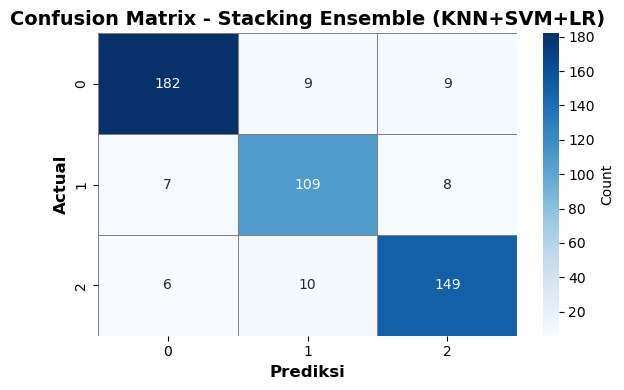


📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     negatif       0.93      0.91      0.92       200
      netral       0.85      0.88      0.87       124
     positif       0.90      0.90      0.90       165

    accuracy                           0.90       489
   macro avg       0.89      0.90      0.90       489
weighted avg       0.90      0.90      0.90       489

🎯 ACCURACY: 0.8998 (89.98%)

📊 Distribusi prediksi:
   positif: 166 (33.95%)
   negatif: 195 (39.88%)
   netral: 128 (26.18%)


In [9]:
# EVALUASI MODEL
print("\n\n📈 STEP 8: EVALUASI MODEL")
print("-" * 60)

print("⏳ Proses transformasi data test dan prediksi...")
X_test_tfidf = tfidf.transform(X_test).toarray()
y_pred = model.predict(X_test_tfidf)

print("✅ Prediksi selesai!")
print(f"📊 Jumlah prediksi: {len(y_pred)}")

# Confusion Matrix
print("\n📊 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
# Get classes from the meta model
classes = model.final_estimator_.classes_
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print(cm_df)

# Visualisasi Confusion Matrix
print("\n⏳ Membuat visualisasi Confusion Matrix...")
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')

plt.xlabel('Prediksi', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Stacking Ensemble (KNN+SVM+LR)', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save confusion matrix
plt.savefig('confusion_matrix_stacking.png', dpi=300, bbox_inches='tight')
print("✅ Confusion Matrix disimpan sebagai: confusion_matrix_stacking.png")
plt.show()

# Classification Report
print("\n📊 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"🎯 ACCURACY: {acc:.4f} ({acc*100:.2f}%)")

# Prediksi per kelas
print("\n📊 Distribusi prediksi:")
pred_dist = Counter(y_pred)
for label, count in pred_dist.items():
    print(f"   {label}: {count} ({count/len(y_pred)*100:.2f}%)")



📊 STEP 9: ROC CURVE ANALYSIS
------------------------------------------------------------
📊 Jumlah kelas: 3
📊 Kelas: [0 1 2]
✅ ROC AUC untuk kelas '0': nan
✅ ROC AUC untuk kelas '1': nan
✅ ROC AUC untuk kelas '2': nan

📊 ROC AUC (Micro-average): nan
📊 ROC AUC (Macro-average): nan

⏳ Membuat visualisasi ROC Curve...
✅ ROC Curve disimpan sebagai: roc_curve_stacking.png


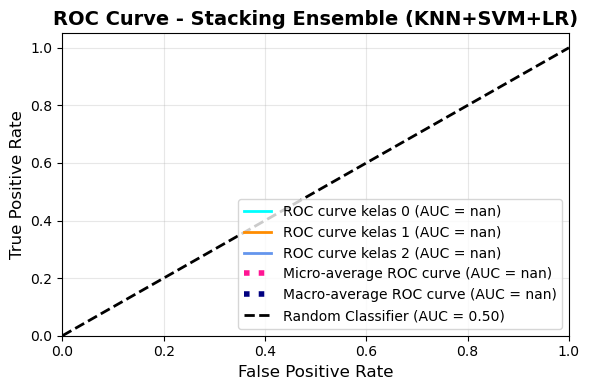

In [10]:
# ROC CURVE ANALYSIS
print("\n\n📊 STEP 9: ROC CURVE ANALYSIS")
print("-" * 60)

# Get probability predictions
y_score = model.predict_proba(X_test_tfidf)

# Get unique classes
n_classes = len(classes)

print(f"📊 Jumlah kelas: {n_classes}")
print(f"📊 Kelas: {classes}")

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"✅ ROC AUC untuk kelas '{classes[i]}': {roc_auc[i]:.4f}")

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"\n📊 ROC AUC (Micro-average): {roc_auc['micro']:.4f}")

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print(f"📊 ROC AUC (Macro-average): {roc_auc['macro']:.4f}")

# Plot ROC curves
print("\n⏳ Membuat visualisasi ROC Curve...")
plt.figure(figsize=(6, 4))

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve kelas {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Stacking Ensemble (KNN+SVM+LR)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save ROC curve
plt.savefig('roc_curve_stacking.png', dpi=300, bbox_inches='tight')
print("✅ ROC Curve disimpan sebagai: roc_curve_stacking.png")
plt.show()



In [11]:
# SAVE MODEL
print("\n\n💾 STEP 10: MENYIMPAN MODEL")
print("-" * 60)

dump(tfidf, "tfidf_mbg_stacking.pkl")
print("✅ TF-IDF saved as: tfidf_mbg_stacking.pkl")

dump(model, "model_stacking_mbg.pkl")
print("✅ Model saved as: model_stacking_mbg.pkl")

print("\n" + "="*60)
print("🎉 PROSES SELESAI!")
print("="*60)
print("\n📊 RINGKASAN HASIL:")
print(f"   - Algoritma: Stacking Ensemble")
print(f"   - Base Models: KNN, SVM, Logistic Regression")
print(f"   - Meta Model: Logistic Regression")
print(f"   - Accuracy: {acc*100:.2f}%")
print(f"   - ROC AUC (Macro): {roc_auc['macro']:.4f}")
print(f"   - Jumlah data training: {len(X_train_res)}")
print(f"   - Jumlah data testing: {len(X_test)}")
print(f"   - Cross-validation: 5-fold")
print("="*60)



💾 STEP 10: MENYIMPAN MODEL
------------------------------------------------------------
✅ TF-IDF saved as: tfidf_mbg_stacking.pkl
✅ Model saved as: model_stacking_mbg.pkl

🎉 PROSES SELESAI!

📊 RINGKASAN HASIL:
   - Algoritma: Stacking Ensemble
   - Base Models: KNN, SVM, Logistic Regression
   - Meta Model: Logistic Regression
   - Accuracy: 89.98%
   - ROC AUC (Macro): nan
   - Jumlah data training: 5400
   - Jumlah data testing: 489
   - Cross-validation: 5-fold
